In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from maddeb.Deblender import Deblend
from maddeb.utils import listdir_fullpath
from maddeb.extraction import extract_cutouts

import numpy as np
import os

import matplotlib.pyplot as plt

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

import tensorflow as tf
import tensorflow_probability as tfp
tf.get_logger().setLevel('ERROR')

from maddeb.utils import CustomSampling, get_data_dir_path

2023-09-21 09:19:35.214484: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-09-21 09:19:35.214533: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import seaborn as sns
sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

# Generate the blended scene

In [3]:
COSMOS_CATALOG_PATHS = "/sps/lsst/users/bbiswas/OneDegSq_snr_10.fits"

stamp_size = 41
min_number = 1
max_number = 20
batch_size = 2
maxshift = 15
num_repetations = 15
catalog = btk.catalog.CatsimCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("LSST")
seed = 13

linear_norm_coeff = 10000

sampling_function = btk.sampling_functions.DefaultSampling(
    max_number=max_number, min_number=min_number, max_shift=maxshift, stamp_size=stamp_size, seed=seed
)

draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    augment_data=False,
    verbose=False,
    seed=seed,
)

In [4]:
blend = next(draw_generator)

blend['blend_list'][0]['x_peak']

np.shape(blend['blend_images'][0])

Generating blends for LSST survey:   0%|          | 0/2 [00:00<?, ?it/s]

(6, 205, 205)

### choose the field to deblend

In [5]:
field_to_process = 1

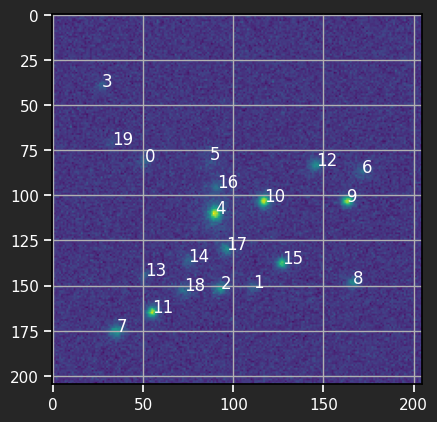

In [6]:
#### print("input_image")
band_num = 2
plt.imshow(blend['blend_images'][field_to_process, band_num])
for i in range(len(blend['blend_list'][field_to_process])):
    plt.text(blend['blend_list'][field_to_process]['x_peak'][i], blend['blend_list'][field_to_process]['y_peak'][i], str(i))

input_image


/tmp/ipykernel_4005/2195325641.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  bar = fig.colorbar(im1, ax=ax)


<Figure size 1000x1000 with 0 Axes>

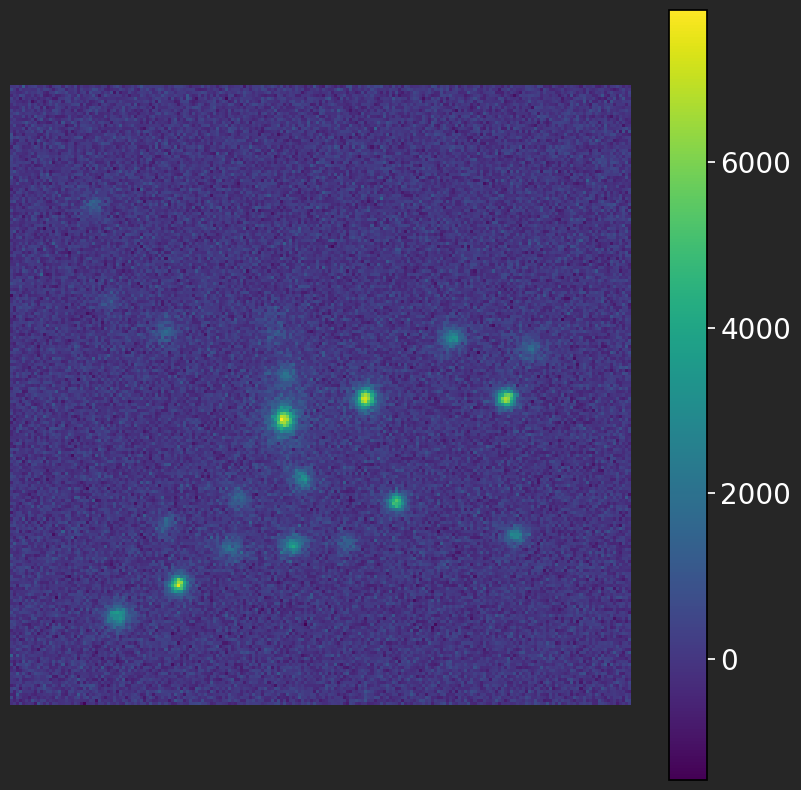

In [7]:
fig = plt.figure(figsize=(10,10))
print("input_image")
fig=plt.figure(figsize=(10,10))
ax=fig.gca()
im1 = ax.imshow(blend['blend_images'][field_to_process, 2])
#for i in range(len(blend['blend_list'][0])):
#    plt.scatter(blend['blend_list'][0]['x_peak'][i], 
#                blend['blend_list'][0]['y_peak'][i], marker="x", c="r")
    #plt.text(blend['blend_list'][0]['x_peak'][i]-1, blend['blend_list'][0]['y_peak'][i]-1, str(i), c='black', fontsize=15)
bar = fig.colorbar(im1, ax=ax)
bar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("input field")


# Initialize the Deblender

In [8]:
tf.get_logger().setLevel('ERROR')

latent_dim = 16
kl_weight = 1

weights_path = os.path.join(get_data_dir_path(), f"catsim_kl{kl_weight}{latent_dim}d")
deb = Deblend(latent_dim=16, weights_path=weights_path)

2023-09-21 09:20:40.613805: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-09-21 09:20:40.613905: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-21 09:20:40.613992: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2023-09-21 09:20:40.614403: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 09

In [9]:

# deb = Deblend(blend['blend_images'][0], 
#               detected_positions,
#               latent_dim=16, 
#               num_components=len(blend['blend_list'][0]), 
#               use_log_prob=True, 
#               linear_norm_coeff=linear_norm_coeff,
#               max_iter=500)



# Test run Debvader

In [10]:
# deb.run_debvader()

In [11]:
# fig, ax = plt.subplots(len(blend['blend_list'][0]), 3, figsize=(5*3,5*len(blend['blend_list'][0])))

# for i in range(len(blend['blend_list'][0])):

#     #print("image number: " + str(i))
#     image_index = i
#     im1 = ax[i, 0].imshow(crop_image(blend['isolated_images'][0][i], detected_positions[i], 9))
#     cbar = fig.colorbar(im1, ax=ax[i, 0])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 0].set_title("ground truth")
#     ax[i, 0].scatter(22, 22, c="r", marker="x")

#     im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i, 1])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 1].set_title("predicted")
    
#     im3 = ax[i, 2].imshow(crop_image(blend['isolated_images'][0][i], detected_positions[i], 9) - deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im3, ax=ax[i, 2])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 2].set_title("actual - predicted")
    
# plt.show()

In [12]:
# #Residual after debvader run

# fig = plt.figure(figsize=(10,10))
# ax = fig.gca()
# padding_infos = deb.get_padding_infos()
# residual = deb.compute_residual(np.transpose(blend['blend_images'][field_to_process], axes=[1, 2, 0]), use_scatter_and_sub=True).numpy()
# #residual = np.transpose(deb.postage_stamp, 
# im1 = ax.imshow(residual[:, :, 3])
# cbar =fig.colorbar(im1, ax=ax)
# cbar.ax.tick_params(labelsize=20)
# plt.savefig("residual")

In [13]:
# fig, ax = plt.subplots(len(blend['blend_list'][0]), 2, figsize=(5*2,5*len(blend['blend_list'][0])))

# for i in range(len(blend['blend_list'][0])):

#     im1 = ax[i, 0].imshow(extract_cutouts(blend['isolated_images'][0][i], [detected_positions[i]], distances_to_center=False, cutout_size=45)[0][0, :, :, 2])
#     cbar = fig.colorbar(im1, ax=ax[i, 0])
#     cbar.ax.tick_params(labelsize=20)
#     ax[i, 0].set_title("ground truth", fontsize=20)
#     ax[i, 0].scatter(22, 22, c="r", marker="x")
#     ax[i, 0].axis('off')


#     im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i, 1])
#     cbar.ax.tick_params(labelsize=20)
#     ax[i, 1].set_title("predicted", fontsize=20)
#     ax[i, 1].axis('off')

# plt.show()

# Run MADNESS

In [14]:
import tensorflow_addons as tfa
# convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(
#     atol=0.000001 * 45 * 45 * len(blend) * 3, min_num_steps=80, window_size=20
# )

# convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(
#     atol=0.0001 * 45 * 45 * len(blend) * 3, rtol=.001, min_num_steps=80, window_size=20
# )

convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(
    rtol=.001, 
    atol=0.0001 * 45 * 45 * len(blend) * 3, 
    min_num_steps=60, 
    window_size=25,
)
# convergence_criterion = None
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.3, decay_steps=30, decay_rate=0.9, staircase=False,
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
#optimizer=tfa.optimizers.AdaBelief(learning_rate=lr_scheduler)

detected_positions = []
for i in range(len(blend['blend_list'][field_to_process])):
    detected_positions.append([blend['blend_list'][field_to_process]['y_peak'][i], blend['blend_list'][field_to_process]['x_peak'][i]])

deb(postage_stamp=blend['blend_images'][field_to_process], 
    detected_positions=detected_positions,
    num_components=len(blend['blend_list'][field_to_process]), 
    use_log_prob=True, 
    linear_norm_coeff=linear_norm_coeff,
    max_iter=500,
    convergence_criterion=convergence_criterion,
    optimizer=optimizer,
    use_debvader=True,
    compute_sig_dynamically=False,
)

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Using encoder for initial point

--- Starting gradient descent in the latent space ---
Maximum number of iterations: 500
Number of Galaxies: 20
Dimensions of latent space: 16


[0.0038861825596541166, 0.015662619844079018, 0.03558625280857086, 0.04298649728298187, 0.05065583437681198, 0.05400116741657257]


--- Gradient descent complete ---

Time taken for gradient descent: 29.607558727264404


tf.Tensor(
[136020.42  139770.05  132083.38  130088.836 131826.9   131691.73
 130509.99  129905.375 129629.54  129091.61  128608.15  128418.86
 128286.164 128079.56  127943.516 127863.5   127706.625 127442.93
 127265.5   127264.016 127301.266 127201.875 127029.484 126936.76
 126935.62  126909.766 126805.04  126688.41  126610.18  126569.48
 126546.21  126531.62  126515.    126478.47  126434.77  126407.08
 126384.32  126351.73  126322.734 126307.71  126293.06  126267.74
 126245.04  126232.79  126222.586 126209.305 126197.86  126192.45
 126185.78  126176.555 126171.    126166.32  126158.19  126150.664
 126148.95  126147.47  126141.84  126137.53  126136.1   126133.9
 126131.625 126130.08  126126.805 126123.445 126122.1   126120.95
 126118.36  126116.055 126115.17  126114.35  126112.51  126110.9
 126110.43  126109.4   126107.92  126106.97  126106.31  126105.52
 126104.61  126103.625 126102.73  126101.96  126101.23  126100.54
 126099.87  126099.42  126098.9   126098.1   126097.445 126096.92


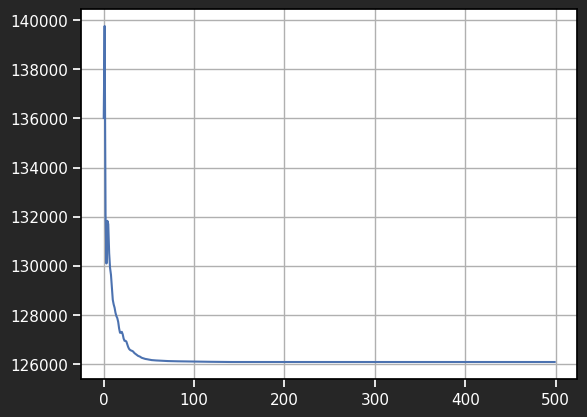

In [15]:
print(deb.results)
plt.plot(deb.results);

/tmp/ipykernel_4005/3721990719.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im1, ax=ax[i, 0])
/tmp/ipykernel_4005/3721990719.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im1, ax=ax[i, 1])
/tmp/ipykernel_4005/3721990719.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im2, ax=ax[i, 2])
/tmp/ipykernel_4005/3721990719.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


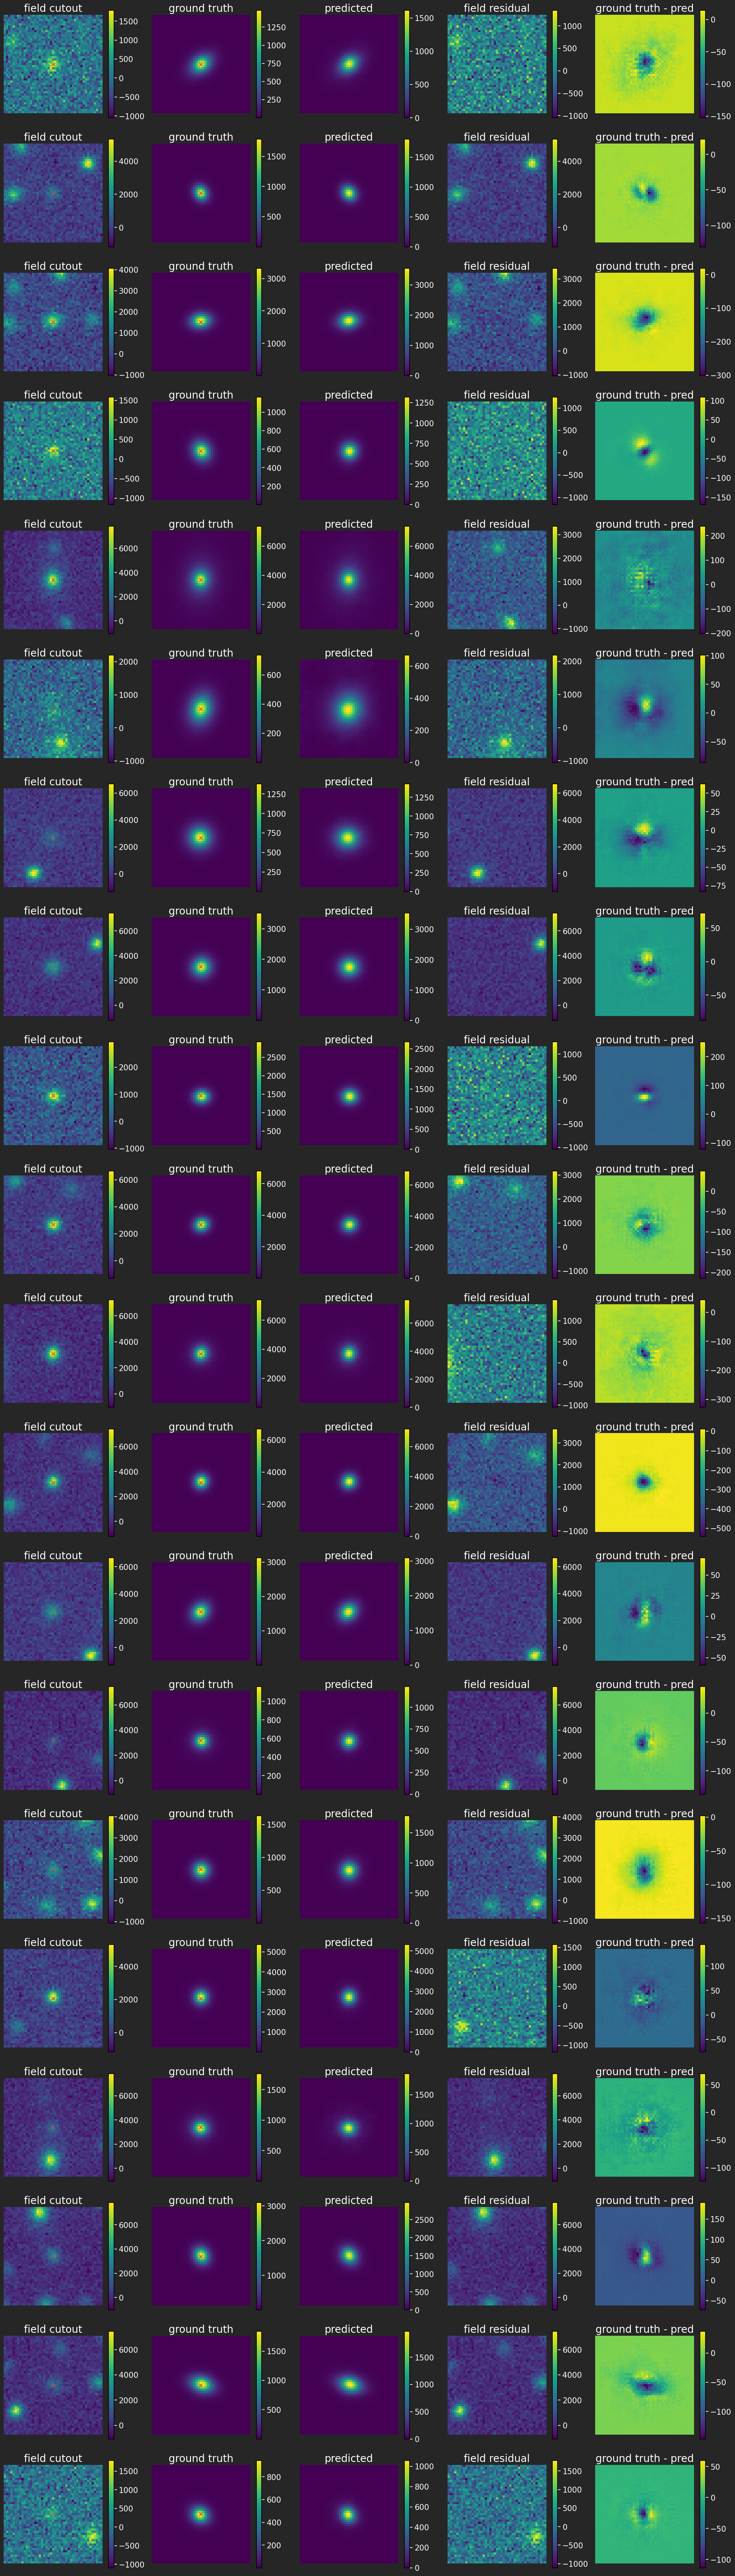

In [16]:
fig, ax = plt.subplots(len(blend['blend_list'][field_to_process]), 5, figsize=(5*5,5*len(blend['blend_list'][0])))

for i in range(len(blend['blend_list'][field_to_process])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]
    field_cutout_r_band = extract_cutouts(blend['blend_images'][field_to_process], [detected_positions[i]], distances_to_center=False, channel_last=False, cutout_size=45)[0][0,:, :, 2]
    galaxy_cutout_r_band = extract_cutouts(blend['isolated_images'][field_to_process][i], [detected_positions[i]], distances_to_center=False, cutout_size=45)[0][0, :, :, 2]
    
    im1 = ax[i, 0].imshow(field_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 0])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 0].set_title("field cutout", fontsize=20)
    ax[i, 0].scatter(22, 22, c="r", marker="x")
    ax[i, 0].axis('off')

    im1 = ax[i, 1].imshow(galaxy_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 1])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 1].set_title("ground truth", fontsize=20)
    ax[i, 1].scatter(22, 22, c="r", marker="x")
    ax[i, 1].axis('off')


    im2 = ax[i, 2].imshow(deb.components[i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i, 2])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 2].set_title("predicted", fontsize=20)
    ax[i, 2].axis('off')
    
    im3 = ax[i, 3].imshow(field_cutout_r_band - deb.components[i][:, :, 2])
    cbar = fig.colorbar(im3, ax=ax[i, 3])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 3].set_title("field residual", fontsize=20)
    ax[i, 3].axis('off')

    
    im3 = ax[i, 4].imshow(galaxy_cutout_r_band - deb.components[i][:, :, 2])
    cbar = fig.colorbar(im3, ax=ax[i, 4])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 4].set_title("ground truth - pred", fontsize=20)
    ax[i, 4].axis('off')

plt.savefig("MAP_predictions")
plt.show()

In [17]:
# fig, ax = plt.subplots(1, len(blend['blend_list'][0]), figsize=(5*len(blend['blend_list'][0]), 5*1))
# for i in range(len(blend['blend_list'][0])):

#     #print("image number: " + str(i))
#     #image_index = shuffled_indices[i]

#     im2 = ax[i].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i].axis("off")
#     #ax[i].set_title("predicted")
# plt.savefig("predictions")

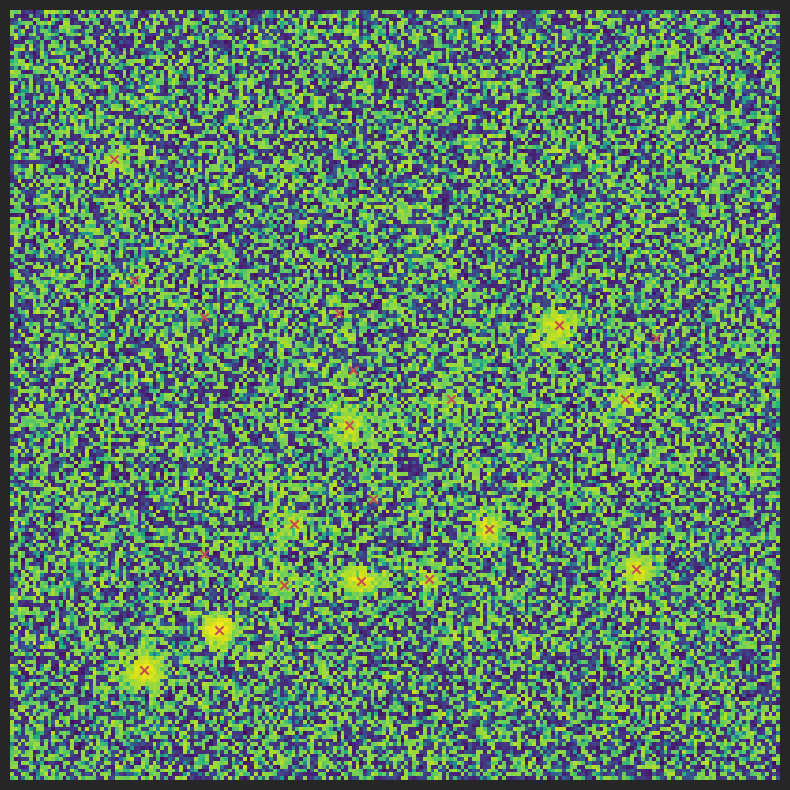

In [18]:
# This is just to make the blends more visible

sns.set_theme(style={"axes.grid": False,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(np.arcsinh(blend['blend_images'][field_to_process][0]))
for i in range(len(blend['blend_list'][field_to_process])):
    plt.scatter(blend['blend_list'][field_to_process]['x_peak'][i], 
                blend['blend_list'][field_to_process]['y_peak'][i], marker="x", c="r")

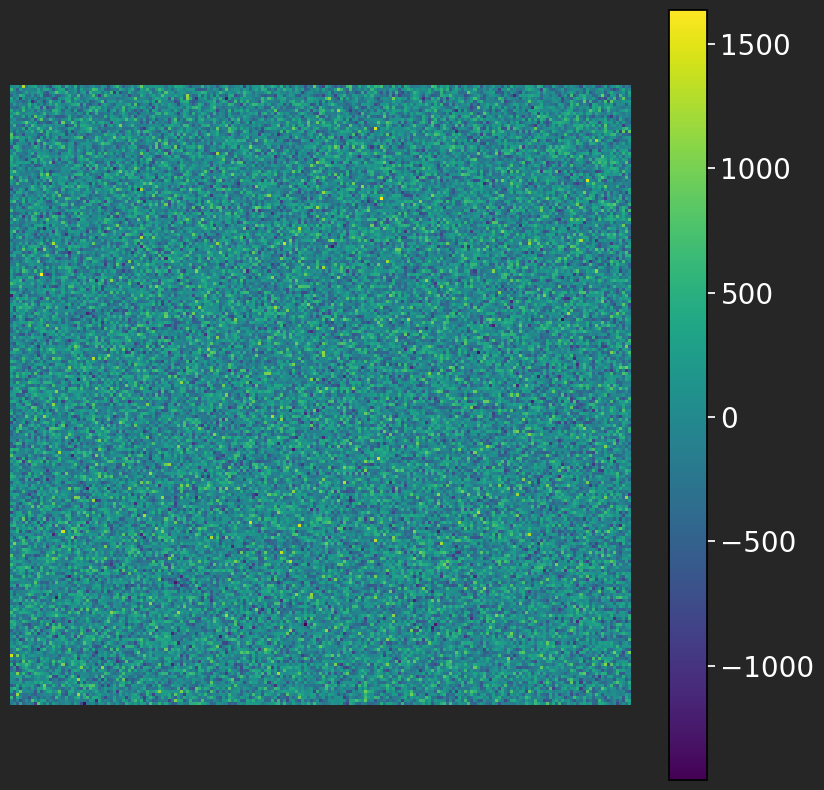

In [19]:
# Residual after MADNESS run
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
tf.config.run_functions_eagerly(True)

padding_infos = deb.get_padding_infos()
residual = deb.compute_residual(np.transpose(blend['blend_images'][field_to_process], axes=[1, 2, 0]), use_scatter_and_sub=True).numpy()
#residual = np.transpose(deb.postage_stamp, 
im1 = ax.imshow(residual[:, :, 2])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("residual")

#for i in range(len(blend['blend_list'][0])):
    #plt.scatter(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], marker="x", linewidths=.5, s=120, c="r")

##### sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

plt.figure(figsize=(8,3))
residual_flattened = residual[:, :, 0].flatten()
print(np.shape(residual_flattened))
plt.hist(residual_flattened, bins=50)
plt.xticks(fontsize=15)
plt.yticks([])

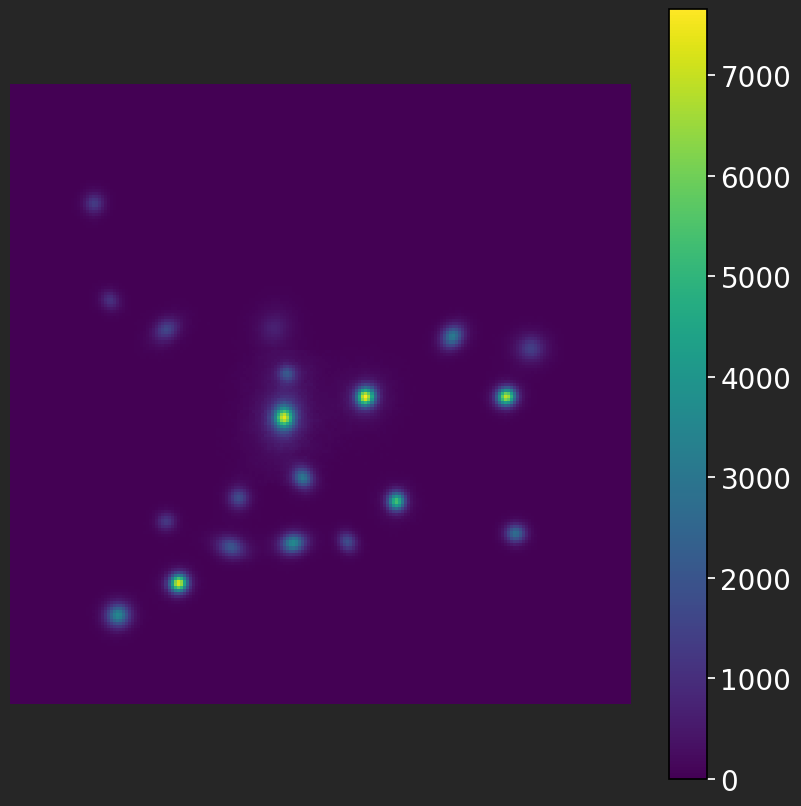

In [20]:
sns.set_theme(style={"axes.grid": False,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})
predicted_field = blend['blend_images'][field_to_process] - np.transpose(residual, axes=[2, 0, 1])
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
im1 = ax.imshow(predicted_field[2, :, :])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.show();